In [367]:
import os
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 146 (delta 78), reused 77 (delta 28), pack-reused 0
Receiving objects: 100% (146/146), 18.20 MiB | 12.00 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [368]:
data_objs = utils.get_physionet_data(10)

(6400, 203, 83) (1600, 168, 83)


In [395]:
dim = data_objs['input_dim']

In [396]:
print(dim),# so 41 dims to account for, and 41 masks  and 1 tp vector? 

41


In [369]:
train_loader = data_objs['train_dataloader']

In [371]:
pbatch = next(iter(train_loader))

In [372]:
pbatch.shape

torch.Size([10, 203, 83])

In [408]:
pbatch[0,:,-1] # time values ?

# masks are dim: 2* dim
# time is -1
# values are :dim

tensor([0.0000, 0.0010, 0.0063, 0.0270, 0.0373, 0.0480, 0.0687, 0.0897, 0.1047,
        0.1103, 0.1313, 0.1520, 0.1730, 0.1937, 0.2147, 0.2353, 0.2563, 0.2770,
        0.2980, 0.3187, 0.3203, 0.3397, 0.3603, 0.3813, 0.3917, 0.4020, 0.4230,
        0.4437, 0.4647, 0.4853, 0.5063, 0.5270, 0.5480, 0.5687, 0.5897, 0.6103,
        0.6313, 0.6520, 0.6730, 0.6937, 0.7147, 0.7353, 0.7563, 0.7770, 0.7980,
        0.8187, 0.8397, 0.8403, 0.8813, 0.9020, 0.9073, 0.9230, 0.9333, 0.9437,
        0.9647, 0.9853, 0.9957, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [398]:
union_tp = utils.union_time(train_loader)

In [399]:
union_tp.shape

torch.Size([2881])

In [ ]:
lc_files = glob('/content/hetvae/data/EDELSON/*')

In [464]:
lc_files * 10

['/content/hetvae/data/EDELSON/NGC5548_W1.dat',
 '/content/hetvae/data/EDELSON/NGC4593_SX.dat',
 '/content/hetvae/data/EDELSON/NGC4593_W1.dat',
 '/content/hetvae/data/EDELSON/NGC4593_HX.dat',
 '/content/hetvae/data/EDELSON/NGC5548_HX.dat',
 '/content/hetvae/data/EDELSON/NGC4593_M2.dat',
 '/content/hetvae/data/EDELSON/NGC5548_SX.dat',
 '/content/hetvae/data/EDELSON/NGC5548_M2.dat',
 '/content/hetvae/data/EDELSON/NGC4593_W2.dat',
 '/content/hetvae/data/EDELSON/NGC5548_W2.dat',
 '/content/hetvae/data/EDELSON/NGC5548_W1.dat',
 '/content/hetvae/data/EDELSON/NGC4593_SX.dat',
 '/content/hetvae/data/EDELSON/NGC4593_W1.dat',
 '/content/hetvae/data/EDELSON/NGC4593_HX.dat',
 '/content/hetvae/data/EDELSON/NGC5548_HX.dat',
 '/content/hetvae/data/EDELSON/NGC4593_M2.dat',
 '/content/hetvae/data/EDELSON/NGC5548_SX.dat',
 '/content/hetvae/data/EDELSON/NGC5548_M2.dat',
 '/content/hetvae/data/EDELSON/NGC4593_W2.dat',
 '/content/hetvae/data/EDELSON/NGC5548_W2.dat',
 '/content/hetvae/data/EDELSON/NGC5548_W

In [490]:
lcs = my_utils.file_to_np(*(lc_files * 50))

# set starting time value to zero 
#lcs = [lc[:,0] - lc[0,0] for lc in lcs]
# normalizing function now! 
for lc in lcs:
  lc[:,0] = lc[:,0] - lc[0,0]
print('-'*50)
lcs = my_utils.handle_dups(lcs)
union_tp = my_utils.union_timepoints(lcs)

print(len(union_tp))

# we want the light curves like
# len_longest_lc, 0 will be time, 1 will be dims 

# lcs = my_utils.include_union_tp(lcs, union_tp)
# lcs.shape # fire!

dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_SX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_SX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of 

In [491]:
max_length_lc = 267

for i, lc in enumerate(lcs):
  length = len(lc)
  need_to_append = max_length_lc - length
  lc = np.append(lc, np.zeros((need_to_append, 3)), axis = 0)
  lcs[i] = lc

In [492]:
lcs = np.array(lcs)
lcs.shape

(500, 267, 3)

In [493]:
# round? 
std_time = np.std(union_tp)
#std_flux = np.std(lcs[:,:,1].flatten())
#mean_flux = np.mean(lcs[:,:,1].flatten())
union_tp = union_tp / std_time
lcs[:,:,0] = lcs[:,:,0] / std_time

In [494]:
lcs = lcs.astype(np.float32)
union_tp = union_tp.astype(np.float32)
union_tp = torch.tensor(union_tp)
train_loader = torch.utils.data.DataLoader(lcs, batch_size=50)

dim = 1



```
# This is formatted as code
```

## Setting up arguments

In [495]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [496]:
args = Namespace(batch_size=50, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.000001, mixing='concat', mse_weight=0.0, n=500, net='hetvae', 
                 niters=2000, norm=True, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

In [497]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [498]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [499]:
lcs.shape

(500, 267, 3)

## **Generating Synthetic Data**

In [500]:
# why is it subtracting 1 for the recon mask?
# dataset class that loads agn by folder you give it? agn object, agn.addLC('').addLC('')
# what is happening with the normalizations...
# kl negative? negative losses in general???
# make this capable of running on GPU
# fixing visualization
# adding error bars in the loss function?
# is my union_tp right? 
# different sequence sizes, some drastically shorter... how to make this not matter? does it? 


# do we subsample the light curve like they do...?
# i guess we do because you're just randomly selecting points each go round...


# make the masks beforehand...
def make_masks(lcs, batch_size):
  # will depend on dimensions later
  subsampled_mask = np.zeros_like(lcs[:,:,1])
  recon_mask = np.zeros_like(lcs[:,:,1])
  for i,lc in enumerate(lcs):
    indexes = lc[:,1].nonzero()[0]
    # this should vary to some extent
    length = int(np.round(len(indexes) * .5))
    obs_points = np.sort(np.random.choice(indexes, size=length, replace=False))
    subsampled_mask[i, obs_points] = 1
    #recon_mask[i] = np.logical_not(subsampled_mask[i])

    recon_mask[i] = np.logical_xor(lc[:,1], subsampled_mask[i])

  recon_mask = np.split(recon_mask, len(subsampled_mask) / batch_size)
  subsampled_mask = np.split(subsampled_mask, len(subsampled_mask) / batch_size)
  return subsampled_mask, recon_mask

smask, rmask = make_masks(lcs, 50)
print(smask[0].shape)


(50, 267)


In [425]:
rmask[0][0]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## **Loading HeTVAE model**

In [427]:
print(smask[0][0].sum(), rmask[0][0].sum())
# right now we are turning every point thats not a 1 in the smask subset to rmask

234.0 26.0


In [501]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=args.lr)


In [ ]:
batch = next(iter(train_loader)) # 2,1644,3
# batch[:,:,0] 2,1644


(34,)

## **Training**

In [502]:
for itr in range(1, args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device) # should look like our flux values?
          recon_mask = torch.tensor(rmask[i][:, :,np.newaxis]).to(device)
          seqlen = train_batch.size(1) 
          context_y = torch.cat((
              train_batch[:, :, 1:2] * subsampled_mask, subsampled_mask
          ), -1) 
    # #   def compute_unsupervised_loss(
    # #     self, context_x, context_y, target_x, target_y, num_samples=1, beta=1.
    # # ):

          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, 0], # context_x, times
              context_y,             # context_y
              train_batch[:, :, 0], # target_x, same times? 
              torch.cat((            # target_y
                  train_batch[:, :, 1:2] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae, # 1? 
              beta=1,       # ? 
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len

      if itr % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  itr,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
    #       for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
    #           utils.evaluate_hetvae(
    #               net,
    #               dim,
    #               loader,
    #               0.5,
    #               shuffle=False,
    #               k_iwae=num_samples,
    #               model_name=args.net,
    #           )

Iter: 100, train loss: 5.1639, avg nll: 3.1310, avg kl: 2.0329, mse: 3.314703, mae: 1.400715
Iter: 200, train loss: 3.1648, avg nll: 2.2170, avg kl: 0.9478, mse: 2.736459, mae: 1.250245
Iter: 300, train loss: 2.1568, avg nll: 1.7279, avg kl: 0.4289, mse: 2.157992, mae: 1.093701
Iter: 400, train loss: 1.6064, avg nll: 1.4174, avg kl: 0.1891, mse: 1.593961, mae: 0.929755
Iter: 500, train loss: 1.2727, avg nll: 1.1856, avg kl: 0.0870, mse: 1.044573, mae: 0.749406
Iter: 600, train loss: 1.0393, avg nll: 0.9937, avg kl: 0.0456, mse: 0.582050, mae: 0.560457
Iter: 700, train loss: 0.8319, avg nll: 0.8025, avg kl: 0.0294, mse: 0.280558, mae: 0.409228
Iter: 800, train loss: 0.6403, avg nll: 0.6154, avg kl: 0.0249, mse: 0.159738, mae: 0.317181
Iter: 900, train loss: 0.5154, avg nll: 0.4920, avg kl: 0.0234, mse: 0.131819, mae: 0.276190
Iter: 1000, train loss: 0.4302, avg nll: 0.4023, avg kl: 0.0279, mse: 0.119080, mae: 0.250394
Iter: 1100, train loss: 0.3282, avg nll: 0.2919, avg kl: 0.0363, mse:

## **Vizualization with increasing number of observations**

In [509]:

torch.cuda.empty_cache()
pred_mean, pred_std = [],[]
masks = []
targets = []
tp = []
k_iwae = 10
np.random.seed(0)
with torch.no_grad():
  batch = next(iter(train_loader)).to(device)
  print(batch.shape)
  batch_len = len(batch)
  subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
  seqlen = batch.size(1)
  context_y = torch.cat((batch[:,:,1:2] * subsampled_mask, subsampled_mask), -1)
  context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
  px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
  pred = px.mean.cpu().numpy()

# def viz(test_loader, k_iwae=1, n_max=5):
#     pred_mean, pred_std = [], []
#     masks = []
#     targets = []
#     tp =[]
#     np.random.seed(0)
#     # don't keep track of gradients....
#     with torch.no_grad():
#         # how many points we show in the light curve? 
#         for low in [30,60,90]:
#             for i, batch in enumerate(test_loader):
#                 batch_len = batch.shape[0]
#                 batch = batch.to(device)
#                 #subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
#                 subsampled_mask = torch.tensor(smask[i][:, :, np.newaxis]).to(device)
#                 seqlen = batch.size(1)
#                 # for i in range(batch_len):
                  
#                 #     length = low
#                 #     obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
#                 #     subsampled_mask[i, obs_points, :] = 1
#                 #recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
#                 context_y = torch.cat((batch[:, :, 1:2] * subsampled_mask, subsampled_mask), -1)
#                 px, _ = net.get_reconstruction(batch[:, :, 0], context_y, batch[:, :, 0], num_samples=k_iwae)
#                 pred_mean.append(px.mean.cpu().numpy())
#                 pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
#                 targets.append((batch[:, :, 1:2]).cpu().numpy())
#                 masks.append(subsampled_mask.cpu().numpy())
#                 tp.append(batch[:, :, 0].cpu().numpy())
#                 if len(tp) % (n_max // 5) == 0:
#                     break
#     pred_mean = np.concatenate(pred_mean, axis=1)
#     pred_std = np.concatenate(pred_std, axis=1)
#     targets = np.concatenate(targets, axis=0)
#     masks = np.concatenate(masks, axis=0)
#     tp = np.concatenate(tp, axis=0)
#     inputs = np.ma.masked_where(masks < 1., targets)
#     print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
#     preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
#     preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
#     median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
#     quantile2 = np.quantile(preds, 0.850, axis=0)
#     quantile1 = np.quantile(preds, 0.150, axis=0)
#     print(preds.shape)
#     print(preds)
    
#     w = 2.0
#     for index in range(n_max):
#         plt.figure(figsize=(12, 1.5))
#         for j in range(3):
#             plt.subplot(1, 3, j + 1)
#             plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
#             plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
#             #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
#             plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
#             plt.xlim([0, 1])
#             plt.xticks([])
#             plt.yticks([])
#             if j == 1 and index == 0:
#                 plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
#         plt.show()


torch.Size([50, 267, 3])


RuntimeError: ignored

In [433]:
points = batch.cpu().numpy()


In [ ]:
points[0,:,1]

3.68

In [438]:
points.shape

(2, 267, 3)

In [ ]:

std_flux = np.std(points[:, :, 1].flatten())
print(std_flux)
#points[:,:,1] = points[:,:,1] / std_flux
print(std_flux)

0.7733767
0.7733767


In [434]:
zeros = points[0,:,1] == 0
points[0,zeros,1] = float('nan')

In [437]:
pred.shape

(10, 2, 267, 1)

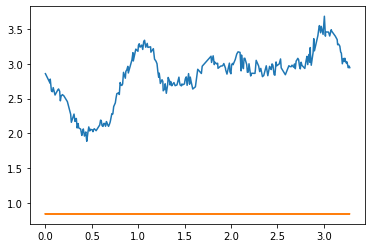

In [445]:
pred.shape # k, batch, num points.... so k samples, for each batch, for each time point 

fig, ax = plt.subplots()
# normalizing problem? 
ax.plot(points[0,:,0], points[0,:,1])
ax.plot(points[0,:,0], pred[0,0,:,0])

In [ ]:
batch = next(iter(train_loader))[:,:,1]

(2, 150, 267, 1) (2, 150, 267, 1) (150, 267, 1) (150, 267, 1) (150, 267)
(2, 150, 267, 1)
[[[[3.49987849]
   [2.95151652]
   [3.18413556]
   ...
   [2.01212007]
   [2.8665227 ]
   [3.00125827]]

  [[0.65858017]
   [0.59493133]
   [0.66001376]
   ...
   [0.708485  ]
   [0.83973135]
   [0.65482373]]

  [[1.06113896]
   [1.18344811]
   [1.24048888]
   ...
   [1.21177887]
   [1.1403722 ]
   [1.53521947]]

  ...

  [[3.29376314]
   [2.47890308]
   [4.04296721]
   ...
   [2.72359093]
   [3.2950197 ]
   [3.68834579]]

  [[1.51596492]
   [0.75354343]
   [1.28798808]
   ...
   [1.16176691]
   [1.21736271]
   [1.3918076 ]]

  [[4.66826721]
   [3.45869127]
   [3.43818818]
   ...
   [3.69646437]
   [3.80466969]
   [3.53169621]]]


 [[[2.81660487]
   [1.82030786]
   [2.85032485]
   ...
   [3.14288207]
   [2.65933462]
   [3.14839671]]

  [[0.36052147]
   [0.81817679]
   [0.51088105]
   ...
   [0.97640022]
   [0.55489427]
   [0.3438518 ]]

  [[1.23253718]
   [1.27523018]
   [1.17029777]
   ...
   [1.

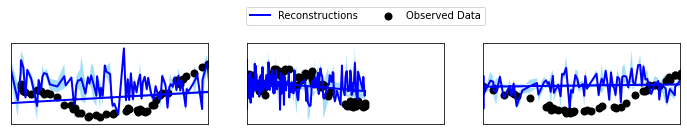

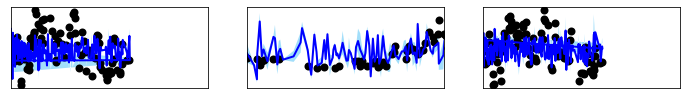

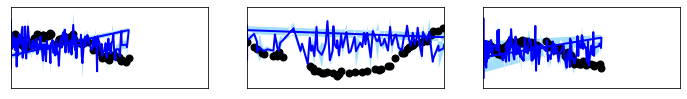

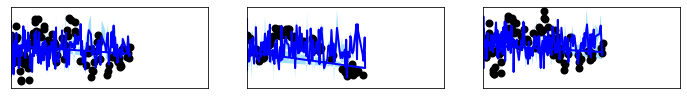

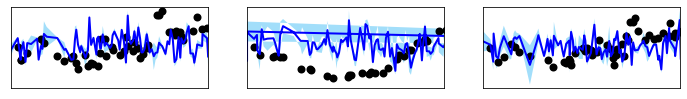

In [506]:
viz(train_loader, k_iwae=2)